<a href="https://colab.research.google.com/github/maryamsalman28/Final-Year-Project--First-Aid-App/blob/main/finalyear_burn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- HARD RESET OF ENV STACK (no imports in this cell) ---

# 1) Wipe caches and conflicting packages
!pip -q uninstall -y torch torchvision torchaudio pillow numpy opencv-python opencv-python-headless opencv-contrib-python >/dev/null
!pip -q cache purge

# 2) Upgrade pip to avoid old resolver edge-cases
!python -m pip -q install --upgrade pip

# 3) Install PyTorch (CUDA 11.8 build works on CPU too)
!pip -q install torch==2.2.0 torchvision==0.17.0 torchaudio==2.2.0 --index-url https://download.pytorch.org/whl/cu118

# 4) Install core, version-pinned libs (use --no-deps to stop resolver tug-of-war)
!pip -q install --no-deps numpy==1.26.4
!pip -q install --no-deps Pillow==10.3.0
!pip -q install --no-deps opencv-python-headless==4.9.0.80

# 5) Utility libs (these don’t fight NumPy/Pillow)
!pip -q install matplotlib==3.8.4 scikit-learn==1.4.2 tqdm==4.66.4

# IMPORTANT: Do not import anything yet.
print("Installed. Now do: Runtime -> Restart runtime, then run the next cell.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires pillow>=9.0.0, which is not installed.
fastai 2.7.19 requires torch<2.7,>=1.10, which is not installed.
fastai 2.7.19 requires torchvision>=0.11, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.24 requires opencv-python-headless>=4.9.0.80, which is not installed.
dopamine-rl 4.1.2 requires opencv-python>=3.4.8.29, which is not installed.
albumentations 2.0.8 requires opencv-python-headless>=4.9.0.80, which is not installed.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.1.2 which is incompatible.
ERROR: pip's dependency resolver does not cur

In [ ]:
# Import only after the runtime restart to avoid mixed-wheel issues
import numpy as np
import cv2
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True  # guards against partially-downloaded images

import torch, torchvision

print("Torch:", torch.__version__, "| Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("NumPy:", np.__version__, "| Pillow:", Image.__version__, "| OpenCV:", cv2.__version__)


Torch: 2.2.0+cu118 | Torchvision: 0.17.0+cu118
CUDA available: True
NumPy: 1.26.4 | Pillow: 10.3.0 | OpenCV: 4.9.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_NAME = "finalyear_burn"

# Your RAW dataset must contain 3 subfolders:
# "1st degree burn", "2nd degree burn", "3rd degree burn"
RAW_DATA_DIR = "/content/drive/MyDrive/burn_dataset_raw"  # <-- change if needed

WORK_DIR = f"/content/{PROJECT_NAME}"
MODEL_DIR = f"{WORK_DIR}/models"
PROCESSED_DATA_DIR = f"{WORK_DIR}/burn_dataset"  # we will write train/val/test here

import os
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print("WORK_DIR:", WORK_DIR)
print("RAW_DATA_DIR:", RAW_DATA_DIR)
print("PROCESSED_DATA_DIR:", PROCESSED_DATA_DIR)
print("MODEL_DIR:", MODEL_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
WORK_DIR: /content/finalyear_burn
RAW_DATA_DIR: /content/drive/MyDrive/burn_dataset_raw
PROCESSED_DATA_DIR: /content/finalyear_burn/burn_dataset
MODEL_DIR: /content/finalyear_burn/models


In [ ]:
import os, shutil, random
from glob import glob
from PIL import Image, UnidentifiedImageError, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

random.seed(42)

SRC = RAW_DATA_DIR
DST = PROCESSED_DATA_DIR
splits = ['train','val','test']
classes = ['1st degree burn','2nd degree burn','3rd degree burn']

#  target folders
for s in splits:
    for cls in classes:
        os.makedirs(os.path.join(DST, s, cls), exist_ok=True)

def valid_image(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except (UnidentifiedImageError, OSError):
        return False

def split_copy_one_class(class_name, train_ratio=0.7, val_ratio=0.15):
    files = glob(os.path.join(SRC, class_name, '*'))
    files = [f for f in files if os.path.isfile(f) and valid_image(f)]
    random.shuffle(files)
    n = len(files)
    n_train = int(n*train_ratio)
    n_val = int(n*val_ratio)
    train_files = files[:n_train]
    val_files   = files[n_train:n_train+n_val]
    test_files  = files[n_train+n_val:]

    def cp(fs, split_name):
        for f in fs:
            shutil.copy2(f, os.path.join(DST, split_name, class_name, os.path.basename(f)))

    cp(train_files, 'train')
    cp(val_files, 'val')
    cp(test_files, 'test')
    return len(train_files), len(val_files), len(test_files)

totals = {cls: split_copy_one_class(cls) for cls in classes}
totals


{'1st degree burn': (739, 158, 159),
 '2nd degree burn': (684, 146, 148),
 '3rd degree burn': (357, 76, 77)}

In [ ]:
import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

IMG_SIZE = 224
BATCH_SIZE = 32

# Use PILToTensor + ConvertImageDtype to avoid ToTensor's NumPy path
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.PILToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(os.path.join(PROCESSED_DATA_DIR,'train'), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(PROCESSED_DATA_DIR,'val'),   transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(PROCESSED_DATA_DIR,'test'),  transform=eval_tfms)

class_names = train_ds.classes
print("Classes:", class_names)

# Keep workers at 0 to avoid multiprocessing import issues in Colab
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False)

print(f"Train images: {len(train_ds)} | Val images: {len(val_ds)} | Test images: {len(test_ds)}")


Classes: ['1st degree burn', '2nd degree burn', '3rd degree burn']
Train images: 1780 | Val images: 380 | Test images: 384


In [ ]:
from PIL import Image
from torchvision import transforms as T

assert len(train_ds) > 0, "Train set is empty. Check RAW_DATA_DIR and folder names."
sample_path = train_ds.samples[0][0]
img = Image.open(sample_path).convert('RGB')
t = T.Compose([T.PILToTensor(), T.ConvertImageDtype(torch.float32)])(img)
print("OK. Tensor shape:", t.shape, "dtype:", t.dtype, "min/max:", float(t.min()), float(t.max()))


OK. Tensor shape: torch.Size([3, 408, 612]) dtype: torch.float32 min/max: 0.027450980618596077 0.8313725590705872


In [ ]:
from collections import Counter
import torch

targets = [y for _, y in train_ds.samples]
counts = Counter(targets)
num_samples = sum(counts.values())
class_count = [counts[i] for i in range(len(class_names))]
class_weights = [num_samples/c for c in class_count]
class_weights = torch.tensor(class_weights, dtype=torch.float32)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights = class_weights.to(device)

print("Class counts:", dict(counts))
print("Class weights:", class_weights)


Class counts: {0: 739, 1: 684, 2: 357}
Class weights: tensor([2.4087, 2.6023, 4.9860], device='cuda:0')


In [ ]:
import torch.nn as nn
import torchvision.models as models

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, 3)  # 3 classes
model = model.to(device)

# Fine-tune all layers
for p in model.features.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=class_weights)  # drop weight=... if classes are balanced
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print("Model ready on:", device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 92.6MB/s]


Model ready on: cuda


In [ ]:
from tqdm import tqdm
import torch

def run_epoch(loader, train_mode=True):
    model.train() if train_mode else model.eval()
    total, correct, running_loss = 0, 0, 0.0
    for imgs, labels in tqdm(loader, disable=False):
        imgs, labels = imgs.to(device), labels.to(device)

        if train_mode:
            optimizer.zero_grad()

        with torch.set_grad_enabled(train_mode):
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            if train_mode:
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total

EPOCHS = 12
best_val_acc = 0.0
best_path = f"{MODEL_DIR}/mobilenetv2_burn_best.pth"

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = run_epoch(train_loader, True)
    va_loss, va_acc = run_epoch(val_loader, False)
    scheduler.step()
    print(f"Epoch {epoch}: train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        torch.save(model.state_dict(), best_path)
        print("Saved new best model.")
print("Best val acc:", best_val_acc)


100%|██████████| 12/12 [00:02<00:00,  5.85it/s]


Epoch 1: train loss 0.7848 acc 0.6264 | val loss 0.6920 acc 0.7105
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch 2: train loss 0.5309 acc 0.7725 | val loss 0.5933 acc 0.7526
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  5.81it/s]


Epoch 3: train loss 0.4283 acc 0.8258 | val loss 0.5529 acc 0.7842
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  4.25it/s]


Epoch 4: train loss 0.3318 acc 0.8702 | val loss 0.5380 acc 0.7947
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


Epoch 5: train loss 0.2933 acc 0.8876 | val loss 0.5788 acc 0.7842


100%|██████████| 12/12 [00:01<00:00,  6.02it/s]


Epoch 6: train loss 0.2358 acc 0.9039 | val loss 0.4825 acc 0.8237
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  5.76it/s]


Epoch 7: train loss 0.1922 acc 0.9303 | val loss 0.5298 acc 0.8132


100%|██████████| 12/12 [00:02<00:00,  5.87it/s]


Epoch 8: train loss 0.1958 acc 0.9253 | val loss 0.5125 acc 0.8237


100%|██████████| 12/12 [00:02<00:00,  4.53it/s]


Epoch 9: train loss 0.1695 acc 0.9376 | val loss 0.5034 acc 0.8421
Saved new best model.


100%|██████████| 12/12 [00:02<00:00,  4.12it/s]


Epoch 10: train loss 0.1733 acc 0.9320 | val loss 0.5607 acc 0.8237


100%|██████████| 12/12 [00:02<00:00,  5.60it/s]


Epoch 11: train loss 0.1514 acc 0.9354 | val loss 0.5228 acc 0.8211


100%|██████████| 12/12 [00:02<00:00,  4.07it/s]

Epoch 12: train loss 0.1452 acc 0.9360 | val loss 0.5478 acc 0.8184
Best val acc: 0.8421052631578947


100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Test loss: 0.5566 | Test accuracy: 0.8021
                 precision    recall  f1-score   support

1st degree burn       0.79      0.89      0.84       159
2nd degree burn       0.80      0.72      0.76       148
3rd degree burn       0.83      0.78      0.81        77

       accuracy                           0.80       384
      macro avg       0.81      0.80      0.80       384
   weighted avg       0.80      0.80      0.80       384



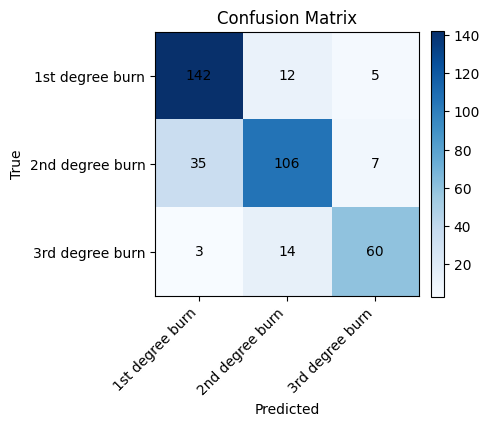

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch

# Load best weights
model.load_state_dict(torch.load(best_path, map_location=device))
model.eval()

all_preds, all_labels = [], []
test_loss, test_correct, total = 0.0, 0, 0

with torch.no_grad():
    for imgs, labels in tqdm(test_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

test_loss /= total
test_acc = test_correct / total
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.4f}")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(cm, cmap='Blues')
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticks(range(len(class_names))); ax.set_yticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right'); ax.set_yticklabels(class_names)

# Annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
# --- 1) Resolve best_path (checkpoint) ---
from pathlib import Path
import glob, os

# If you already defined MODEL_DIR earlier, keep it. Otherwise uncomment the next line:
# MODEL_DIR = "/content/finalyear_burn/models"

candidates = [
    Path(MODEL_DIR) / "mobilenetv2_burn_best.pth",
    Path("/content/drive/MyDrive/finalyear_burn_models/mobilenetv2_burn_best.pth"),
]

best_path = None
for p in candidates:
    if p.exists():
        best_path = p
        break

if best_path is None:
    hits = glob.glob("/content/**/*best*.pth", recursive=True) + \
           glob.glob("/content/drive/**/*best*.pth", recursive=True)
    print("Could not find mobilenetv2_burn_best.pth at expected locations.")
    print("Here are any *.pth files I can see:", hits)
    raise FileNotFoundError("Best weights (.pth) not found. Re-run training or fix path.")

print("Using checkpoint:", best_path)


Using checkpoint: /content/drive/MyDrive/finalyear_burn_models/mobilenetv2_burn_best.pth


In [ ]:
# --- Mount Drive if needed ---
import os
if not os.path.isdir('/content/drive'):
    from google.colab import drive
    drive.mount('/content/drive')

# --- Paths ---
from pathlib import Path
WORK_DIR = Path('/content/finalyear_burn')
MODEL_DIR = WORK_DIR / 'models'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Find files we can use ---
import glob
def find_one(patterns):
    for pat in patterns:
        hits = glob.glob(pat, recursive=True)
        if hits:
            return hits[0], hits
    return None, []

pth_file, pth_hits = find_one([
    str(MODEL_DIR / 'mobilenetv2_burn_best.pth'),
    '/content/drive/MyDrive/**/mobilenetv2_burn_best.pth'
])

pt_file, pt_hits = find_one([
    str(MODEL_DIR / 'burn_classifier_mobile.pt'),
    '/content/drive/MyDrive/**/burn_classifier_mobile.pt'
])

print("Found .pth:", pth_file)
print("Found .pt :", pt_file)

# --- Export to Lite (.ptl) + labels.txt ---
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.mobile_optimizer import optimize_for_mobile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# your class order used in training
class_names = ['1st degree burn', '2nd degree burn', '3rd degree burn']

out_ptl = MODEL_DIR / 'burn_classifier_mobile.ptl'
labels_txt = MODEL_DIR / 'labels.txt'
labels_txt.write_text("\n".join(class_names), encoding='utf-8')

if pth_file:
    # Rebuild the exact model and load weights
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, len(class_names))
    model.to(device).eval()

    state = torch.load(pth_file, map_location=device)
    model.load_state_dict(state)

    example = torch.randn(1, 3, 224, 224, device=device)
    ts = torch.jit.trace(model, example)
    ts = optimize_for_mobile(ts)
    ts._save_for_lite_interpreter(str(out_ptl))
    print('Exported from .pth -> Lite .ptl:', out_ptl)

elif pt_file:
    # Convert existing TorchScript .pt into Lite .ptl
    ts = torch.jit.load(pt_file, map_location='cpu')
    ts = torch.jit.freeze(ts.eval())
    ts = optimize_for_mobile(ts)
    ts._save_for_lite_interpreter(str(out_ptl))
    print('Converted TorchScript .pt -> Lite .ptl:', out_ptl)

else:
    print("Searched for these .pth locations:")
    print(pth_hits)
    print("Searched for these .pt locations:")
    print(pt_hits)
    raise FileNotFoundError(
        "No mobilenetv2_burn_best.pth or burn_classifier_mobile.pt found. "
        "Re-run training (the cell that saves the best .pth), or upload one of these files to Drive."
    )

print('Labels saved to:', labels_txt)


Found .pth: /content/drive/MyDrive/finalyear_burn_models/mobilenetv2_burn_best.pth
Found .pt : /content/drive/MyDrive/finalyear_burn_models/burn_classifier_mobile.pt
Exported from .pth -> Lite .ptl: /content/finalyear_burn/models/burn_classifier_mobile.ptl
Labels saved to: /content/finalyear_burn/models/labels.txt


In [ ]:
import shutil, os
drive_models_dir = "/content/drive/MyDrive/finalyear_burn_models"
os.makedirs(drive_models_dir, exist_ok=True)

for f in [best_path, f"{MODEL_DIR}/burn_classifier_mobile.pt",
          f"{MODEL_DIR}/burn_classifier_mobile.ptl",  # <-- add this
          f"{MODEL_DIR}/labels.txt"]:
    if os.path.exists(f):
        shutil.copy2(f, drive_models_dir)

print("Copied to:", drive_models_dir)


In [ ]:
from PIL import Image
import torch
from torchvision import transforms as T

img_path = train_ds.samples[0][0]  # pick any image path
img = Image.open(img_path).convert('RGB')

infer_tfms = T.Compose([
    T.Resize((224,224)),
    T.PILToTensor(),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

x = infer_tfms(img).unsqueeze(0).to(device)
with torch.no_grad():
    out = model(x)
    prob = torch.softmax(out, dim=1)[0].cpu().numpy()
pred_idx = int(prob.argmax())
print("Pred:", class_names[pred_idx], "| probs:", {class_names[i]: float(prob[i]) for i in range(len(class_names))})


Pred: 1st degree burn | probs: {'1st degree burn': 0.9910016655921936, '2nd degree burn': 0.0085417740046978, '3rd degree burn': 0.00045660932664759457}


In [ ]:
# Ensure models exist then copy to Drive if you want a permanent copy
import shutil, os

drive_models_dir = "/content/drive/MyDrive/finalyear_burn_models"
os.makedirs(drive_models_dir, exist_ok=True)

for f in [best_path, f"{MODEL_DIR}/burn_classifier_mobile.pt", f"{MODEL_DIR}/labels.txt"]:
    if os.path.exists(f):
        shutil.copy2(f, drive_models_dir)

print("Copied to:", drive_models_dir)


Copied to: /content/drive/MyDrive/finalyear_burn_models


In [ ]:
!pip -q install "torch==1.12.1" "torchvision==0.13.1"
import torch, torchvision, sys; print(torch.__version__, torchvision.__version__)
torch.backends.quantized.engine = 'qnnpack'


ERROR: Could not find a version that satisfies the requirement torch==1.12.1 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.12.1
2.6.0+cu124 0.21.0+cu124


In [ ]:
from google.colab import files
uploaded = files.upload()  # choose your weight file and labels.txt if you like
list(uploaded.keys())


Saving burn_classifier_mobile.pt to burn_classifier_mobile.pt
Saving labels.txt to labels.txt


['burn_classifier_mobile.pt', 'labels.txt']

In [ ]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

IN_PT  = "burn_classifier_mobile.pt"   # <-- rename to your .pt
OUT_TS = "burn_classifier_cpu.pt"
OUT_LITE = "burn_classifier_mobile.ptl"

m = torch.jit.load(IN_PT, map_location="cpu").eval()
m = torch.jit.freeze(m)
m.save(OUT_TS)
opt = optimize_for_mobile(m)
opt._save_for_lite_interpreter(OUT_LITE)
print("Wrote:", OUT_TS, OUT_LITE)


Wrote: burn_classifier_cpu.pt burn_classifier_mobile.ptl


In [ ]:
import torch
ts = torch.jit.load("burn_classifier_cpu.pt", map_location="cpu").eval()
with torch.no_grad():
    y = ts(torch.rand(1,3,224,224))
print("Logits shape:", tuple(y.shape))


Logits shape: (1, 3)


In [ ]:
from google.colab import files
files.download("burn_classifier_mobile.ptl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>